(dimensionality)=
# Distribution Dimensionality
PyMC provides a number of ways to specify the dimensionality of its distributions. In this document we provide an overview and current best practices.

## Glossary
In this document we'll be using the term dimensionality to refer to the idea of dimensions. Each of the terms below has a specific
semantic and computational definition in PyMC.  While we share them here they will make much more sense when viewed in the examples below.

+ *Support dimensions* → The core dimensionality of a distribution
+ *Batched dimensions* → Extra dimensions beyond the support dimensionality of a distribution
+ *Implicit dimensions* → Dimensions that follow from the values or shapes of the distribution parameters
+ *Explicit dimensions* → Dimensions that are explicitly defined by one or more of the following arguments:
    + *Shape* → Number of draws from a distribution
    + *Size* → Number of batched dimensions
    + *Dims* → An array of dimension names
+ *Coords* → A dictionary mapping dimension names to coordinate values


## General Recommendations
### When prototyping implicit dimensions are convenient
Implicit dimensions are easy to specify and great for quickly expanding an existing distribution.

### For reusable code we suggest dims
For any more important work, or reusable work we suggest dims and coords as the labels will be passed to {class}'arviz.InferenceData'. This is both best practice transparency and readability for others. It also is useful in single developer workflows, for example, in cases where there is a 3 dimensional or higher distribution it'll help indiciate which dimension corresponds to which model concept.

### Use shape if you'd like to be explicit
Use shape if you'd like to bypass any dimensionality calculations implicit in PyMC. This will strictly specify the dimensionality to Aesara

### When debugging use unique prime numbers
By using prime numbers it will be easier to determine where how input dimensionalities are being converted to output dimensionalities.
Once confident with result then change the dimensionalities to match your data or modeling needs.

In [1]:
import pymc as pm
import numpy as np

## Univariate distribution example
We can start with the simplest case, a single Normal distribution. We specify one outside of a PyMC Model as shown below

In [2]:
normal_dist = pm.Normal.dist()

We can then use the `pm.draw` to take a draw from that same distribution

In [3]:
normal_draw = pm.draw(normal_dist)
normal_draw, normal_draw.shape

(array(-0.20878582), ())

In this case we end up with a single scalar value. This is consistent with the distributions support dimensionality, as the smallest random draw dimension is a scalar which has a dimension of zero. The support dimensionality of every distribution is hard_coded as a property.

In [4]:
normal_dist.owner.op.ndim_supp

0

### Explicit batch dimensions

If one needs more than a single draw, a natural tendency would be to create multiple copies of the same variable and stack them together.

In [5]:
normal_dists = pm.math.stack([pm.Normal.dist() for _ in range(3)])
pm.draw(normal_dists)

array([ 0.18874909, -1.72487846, -0.74330671])

More simply, one can create a *batch* of independent draws from the same distribution family by using the shape or size arguments.

In [6]:
normal_dists = pm.Normal.dist(size=3)
pm.draw(normal_dists)

array([ 0.45616511, -1.09265567,  1.22444712])

For scalar distributions, shape and size are equivalent

In [7]:
normal_dists = pm.Normal.dist(shape=3)
pm.draw(normal_dists)

array([-0.61335381,  0.76041448,  0.34246865])

Not only is this more succint, but it produces much more efficient vectorized code. We rarely use the first approach in PyMC.

### Implicit batch dimensions

It is also possible to create a batch of draws by passing parameters with higher dimensions, without having to specify shape or size.

In [8]:
normal_dists = pm.Normal.dist(mu=np.array([0, 0, 0]), sigma=np.array([1, 1, 1]))
pm.draw(normal_dists)

array([-1.56573057,  0.17834018, -0.0534052 ])

This is equivalent to the previous example with explicit shape and size, and we could have passed one of those arguments explicitly here. Because we did not, we refer to these batched dimensions as being *implicit*.

Where this becomes very useful is when we want the parameters to vary across batched dimensions.

In [9]:
pm.draw(pm.Normal.dist(mu=[1, 10, 100], sigma=0.0001))

array([ 1.00005088, 10.00001614, 99.99992541])

When the parameters don't have the same shapes, they are broacasted, in a similar way to how NumPy works. In this case `sigma` was broadcasted to match the shape of `mu`.

In [10]:
np.broadcast_arrays([1, 10, 100], 0.0001)

[array([  1,  10, 100]), array([0.0001, 0.0001, 0.0001])]

## Multivariate distribution example

Some distributions by definition return more than one value when evaluated. This may be a vector of values or a matrix or an arbitrary multidimensional tensor. An example is the Multivariate Normal, which always returns a vector (an array with one dimension).

In [11]:
mvnormal_dist = pm.MvNormal.dist(mu=np.ones(3), cov=np.eye(3))
mvnormal_draw = pm.draw(mvnormal_dist)
mvnormal_draw, mvnormal_draw.shape

(array([0.59439084, 0.20156665, 1.10092247]), (3,))

As with any distribution, the support dimensionality is specified as a fixed property

In [12]:
mvnormal_dist.owner.op.ndim_supp

1

Even if you specify a MvNormal with a single dimension, you get back a vector!

In [13]:
smallest_mvnormal_dist = pm.MvNormal.dist(mu=[1], cov=[[1]])
smallest_mvnormal_draw = pm.draw(smallest_mvnormal_dist)
smallest_mvnormal_draw, smallest_mvnormal_draw.shape

(array([1.46335572]), (1,))

### Implicit support dimensions

In the MvNormal examples we just saw, the support dimension was actually implicit. Nowhere did we specify we wanted a vector of 3 or 1 draws. This was inferred from the shape of `mu` and `cov`. As such, we refer to it as being an *implicit support dimension*. We could be explicit by using shape, **but not size**.

In [14]:
explicit_mvnormal = pm.MvNormal.dist(mu=np.ones(3), cov=np.eye(3), shape=(3,))
explicit_mvnormal.shape.eval()

array([3])

In [15]:
not_the_same = pm.MvNormal.dist(mu=np.ones(3), cov=np.eye(3), size=(3,))
not_the_same.shape.eval()

array([3, 3])

Size refers to the number of independent batched distributions whereas shape refers to the total number of draws. This is a subtle but important distinction. It is perhaps more apparent when we talk about batched dimensions for multivariate distributions next.

### Explicit batch dimensions

As with univariate distributions, we can add explicit batched dimensions. However, as we just mentioned size and shape now have different meanings. We will use another vector distribution to illustrate this: the Multinomial.

In [16]:
pm.draw(pm.Multinomial.dist(n=5, p=[0.1, 0.3, 0.6], shape=(5, 3)))

array([[0, 2, 3],
       [0, 3, 2],
       [0, 2, 3],
       [0, 3, 2],
       [2, 3, 0]])

In [17]:
pm.draw(pm.Multinomial.dist(n=5, p=[0.1, 0.3, 0.6], size=(5,)))

array([[0, 1, 4],
       [1, 4, 0],
       [0, 3, 2],
       [2, 1, 2],
       [1, 2, 2]])

A size of five reflects the fact that we are sampling a matrix of from 5 independent Multinomial distributions. Each of these Multinomial distributions defines a vector of 3 values that are **not** independent of each other. In this case once we know the first two values of each vector we can infer the third one without ambiguity. Shape, in contrast, simply refers to the dimensions of all the draws combined.

### Implicit batch dimensions

As with univariate distributions, we can use different parameters for each batched dimension

In [18]:
multinomial_dist = pm.Multinomial.dist(n=[5, 10], p=[0.1, 0.3, 0.6])
pm.draw(multinomial_dist)

array([[0, 2, 3],
       [1, 5, 4]])

Which is equivalent to the more verbose

In [19]:
pm.draw(pm.Multinomial.dist(n=[5, 10], p=[[0.1, 0.3, 0.6], [0.1, 0.3, 0.6]]))

array([[0, 2, 3],
       [0, 3, 7]])

If you are familiar with NumPy broadcasting rules you may be curious of how does PyMC make this work. Naive broadcasting wouldn't work here

In [20]:
try:
    np.broadcast_arrays([5, 10], [0.1, 0.3, 0.6])
except ValueError as exc:
    print(exc)

shape mismatch: objects cannot be broadcast to a single shape


Instead, PyMC takes into consideration the number of dimensions that each parameter has in the core case. In the Multinomial distribution, `n` is a scalar and `p` is a vector. So if we have a vector of two `n`, we should actually broadcast the vector of `p` into a `matrix` with two such vectors, and pair each `n` with each broadcasted row of `p`. This works exactly like `np.vectorize` would.

In [21]:
def core_multinomial(n, p):
    print(">>", n, p)
    return pm.draw(pm.Multinomial.dist(n, p))


vectorized_multinomial = np.vectorize(core_multinomial, signature="(),(p)->(p)")
vectorized_multinomial([5, 10], [0.1, 0.3, 0.6])

>> 5 [0.1 0.3 0.6]
>> 10 [0.1 0.3 0.6]


array([[2, 1, 2],
       [0, 5, 5]])

The core dimensionality of each distribution parameter is also hard-coded as a property of each distribution

In [22]:
multinomial_dist.owner.op.ndims_params

(0, 1)

### Combining implicit and explicit dimensions

You can and should combine implicit dimensions from multidimensional parameters with explicit size or shape information, which is easier to reason about.

In [23]:
pm.draw(pm.Multinomial.dist(n=[5, 10], p=[0.1, 0.3, 0.6], shape=(2, 3)))

array([[1, 1, 3],
       [1, 1, 8]])

In [24]:
pm.draw(pm.Multinomial.dist(n=[5, 10], p=[0.1, 0.3, 0.6], size=(2,)))

array([[0, 2, 3],
       [3, 4, 3]])

## Inspecting dimensionality with a model graph
More often that not distributions are used inside a PyMC model, and as such there are tools that facilitate reasoning about distributions shapes in that context.



In [25]:
with pm.Model() as pmodel:
    mu = pm.Normal("x", mu=0, size=(3))
    sigma = pm.HalfNormal("sigma")
    y = pm.Normal("y", mu=mu, sigma=sigma)

pmodel.eval_rv_shapes()

{'x': (3,), 'sigma_log__': (), 'sigma': (), 'y': (3,)}

An even more powerful tool to understand and debug dimensionality in PyMC is the `pm.model_to_graphviz` functionality. Rather than inspecting array outputs we instead can read the Graphviz output to understand the dimensionality.

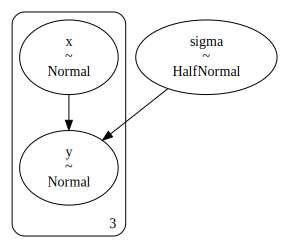

In [26]:
pm.model_to_graphviz(pmodel)

In the example above the number on the bottom left of each box (or plate) indicates the dimensionality of the distributions within. If a distribution is outside of any box with a number, it has a scalar shape.

Let's use this tool to review implicit and explicit dimensions:

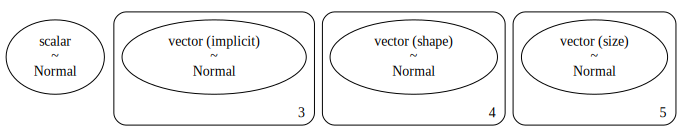

In [27]:
with pm.Model() as pmodel:
    pm.Normal("scalar")  # shape=()
    pm.Normal("vector (implicit)", mu=[1, 2, 3])
    pm.Normal("vector (shape)", shape=(4,))
    pm.Normal("vector (size)", size=(5,))

pm.model_to_graphviz(pmodel)

## Dims
A new feature of PyMC is `dims` support. With many random variables it can become confusing which dimensionality corresponds to which "real world" idea, e.g. number of observations, number of treated units etc. The dims argument is an additional label to help.

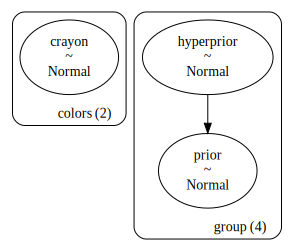

In [28]:
with pm.Model() as pmodel:
    pm.Normal("crayon", size=2, dims="colors")

    pm.Normal("hyperprior", [1, 2, 3, 4], dims="group")
    pm.Normal("prior", dims="group")


pm.model_to_graphviz(pmodel)

Where dims can become increasingly powerful is with the use of `coords` specified in the model itself. With this it becomes easy to track. As an added bonus the coords and dims will also be present in the returned {class}'arviz.InferenceData' simplifying the entire workflow.

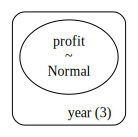

In [29]:
with pm.Model(
    coords={
        "year": [2020, 2021, 2022],
    }
) as pmodel:

    pm.Normal("profit", dims="year")

pm.model_to_graphviz(pmodel)

Note that the dimensionality of the distribution was actually defined by the `dims` used. We did not pass shape or size!

We can use all our dimensionality tools to help us reason about Multivariate distributions as well.

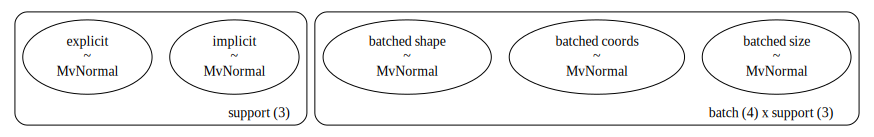

In [30]:
with pm.Model(
    coords={
        "batch": [2019, 2020, 2021, 2022],
    }
) as pmodel:
    pm.MvNormal("implicit", mu=[0, 0, 0], cov=np.eye(3), dims=("support",))
    pm.MvNormal("explicit", mu=[0, 0, 0], cov=np.eye(3), shape=(3,), dims=("support",))

    pm.MvNormal("batched size", mu=[0, 0, 0], cov=np.eye(3), size=4, dims=("batch", "support"))
    pm.MvNormal(
        "batched shape", mu=[0, 0, 0], cov=np.eye(3), shape=(4, 3), dims=("batch", "support")
    )
    pm.MvNormal("batched coords", mu=[0, 0, 0], cov=np.eye(3), dims=("batch", "support"))

pm.model_to_graphviz(pmodel)

## Ellipsis

In [31]:
# TODO

## User caution and practical tips

While we provide all these tools for convenience, and while PyMC does it best to understand user intent, the result of mixed dimensionality tools may not always result in the final dimensionality intended. Sometimes the model may not indicate an error until sampling, or not indicate an issue at all. When working with dimensionality, particular more complex ones we suggest

* Using GraphViz to visualize your model before sampling
* Using `pm.draw` or `pm.sample_prior predictive` to catch errors early
* Inspecting the returned `az.InferenceData` object to ensure all array sizes are as intended